# Introduction

TODO


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from nltk.tokenize import word_tokenize
from autocorrect import spell
import re
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue             
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index].strip() + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                 
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1].strip() + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_words_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:       
        for word in word_tokenize(sentence):
            word = process_word(word)
            if word not in vocab_to_int:
                vocab_to_int[word] = count
                count += 1


    '''''Build inverse translation from int to word'''
    int_to_vocab = {}
    for word, value in vocab_to_int.items():
        int_to_vocab[value] = word
        
    return vocab_to_int, int_to_vocab

In [10]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [11]:
def vectorize_char_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [12]:
def vectorize_hier_data(input_texts, target_texts, max_words_seq_length, max_chars_seq_length, num_char_tokens, num_word_tokens, word2int, char2int):

    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    # 
    encoder_char_input_data = np.zeros(
    (len(input_texts), max_words_seq_length, max_chars_seq_length),
    dtype='float32')
    
    decoder_word_input_data = np.zeros(
        (len(input_texts), max_words_seq_length),
        dtype='float32')
    
    decoder_word_target_data = np.zeros(
        (len(input_texts), max_words_seq_length, num_word_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        words_lst = word_tokenize(input_text)
        if(len(words_lst) > max_words_seq_length):
            continue
        for j, word in enumerate(words_lst):
            if(len(word) > max_chars_seq_length):
                continue
            for k, char in enumerate(word):
                # c0..cn
                if(char in char2int):
                    encoder_char_input_data[i, j, k] = char2int[char]
                    
        words_lst = word_tokenize(target_text)# word_tokenize removes the \t and \n, we need them to start and end a sequence
        words_lst.insert(0, '\t')
        words_lst.append('\n')        
        if(len(words_lst) > max_words_seq_length):
            continue                
        for j, word in enumerate(words_lst):
            processed_word = process_word(word)
            if not processed_word in word2int:
                continue
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_word_input_data[i, j] = word2int[processed_word]
            if j > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_word_target_data[i, j - 1, word2int[processed_word]] = 1.
                
    return encoder_char_input_data, decoder_word_input_data, decoder_word_target_data

In [13]:
def decode_gt_sequence(input_seq, int_to_vocab):

    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_word = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_word + ' '

    return decoded_sentence

In [14]:
def decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_words_seq_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []

    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    i = 0
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
       
        
        #orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(word_tokenize(decoded_sentence)) > max_words_seq_len):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        '''
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        '''
        decoded_sentence += sampled_char + ' '


        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1, max_words_seq_len))
        if i < max_words_seq_len:
            target_seq[0, i] = sampled_token_index

        # Update states
        states_value = [h, c]
        i += 1
        #if i > 48:
        #    i = 0
        

    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [15]:
def decode_char_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [16]:
def build_char_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    #print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    #print(decoder_outputs)
    #print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_encoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    #print('encoder-decoder  model:')
    print(model.summary()) 
    
    #print(encoder_inputs)
    #print(encoder_outputs)
    #print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [17]:
def build_hier_model(encoder_char_model, max_words_seq_len, max_char_seq_len, num_word_tokens, num_char_tokens, latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    decoder_inputs_words = Input(shape=(max_words_seq_len,), dtype='float32')
    words_states = []
    
    for w in range(max_words_seq_len):
        
        encoder_char_inputs = Lambda(lambda x: x[:,w,:])(inputs)
        _, h, c = encoder_char_model(encoder_char_inputs)
        encoder_chars_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        encoder_chars_states = Reshape((1,latent_dim*4))(encoder_chars_states)
        words_states.append(encoder_chars_states)
    
    input_words = Concatenate(axis=-2)(words_states)


    
    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    
    decoder_inputs = decoder_inputs_words
    decoder_inputs_ = Embedding(num_word_tokens, latent_dim*4,                           
                            #weights=[np.eye(num_word_tokens)],
                            mask_zero=True, trainable=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_word_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([inputs, decoder_inputs_words], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(max_words_seq_len, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs_words, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [18]:
'''
_, encoder_char_model, _ = build_char_model(num_encoder_tokens=28, latent_dim=256)
hier_model = build_hier_model(encoder_char_model=encoder_char_model, max_words_seq_len=40, max_char_seq_len=20, num_word_tokens=1000, num_char_tokens=28, latent_dim=256)
'''

'\n_, encoder_char_model, _ = build_char_model(num_encoder_tokens=28, latent_dim=256)\nhier_model = build_hier_model(encoder_char_model=encoder_char_model, max_words_seq_len=40, max_char_seq_len=20, num_word_tokens=1000, num_char_tokens=28, latent_dim=256)\n'

In [19]:
'''
x = Input(shape=(50,))
x = Reshape((1,50))(x)
print(x)
l = []
l.append(x)
l.append(x)
print(l)
y = Concatenate(axis=-2)(l)
print(y)
z = Reshape((-1,2,50))(y)
print(z)
'''

'\nx = Input(shape=(50,))\nx = Reshape((1,50))(x)\nprint(x)\nl = []\nl.append(x)\nl.append(x)\nprint(l)\ny = Concatenate(axis=-2)(l)\nprint(y)\nz = Reshape((-1,2,50))(y)\nprint(z)\n'

In [20]:

def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

In [21]:
def process_word(word):
    # Try to correct the word from known dict
    #word = spell(word)
    # Option 1: Replace special chars and digits
    #processed_word = re.sub(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', r'', w.lower())
    
    # Option 2: skip all words with special chars or digits
    if(len(re.findall(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', word.lower())) == 0):
        #processed_word = word.lower()
        processed_word = word
    else:
        processed_word = 'UNK'

    # Skip stop words
    #stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]        
    stop_words = []
    if processed_word in stop_words:
        processed_word = 'UNK'
        
    return processed_word


# Pre-train char model

## Load data

In [22]:
data_path = '../../dat/'
max_sent_len = 50
min_sent_len = 0

In [23]:
num_samples = 1000
input_texts = []
target_texts = []
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_noise(tess_correction_data, num_file_samples, noise_threshold, max_sent_len, min_sent_len)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

    

In [24]:
len(input_texts)

4000

### Histogram of lenghts

In [25]:

chars_per_words_lengths = []
words_per_sents_lengths = []

# Chars per word should be on all text
for text in (input_texts_OCR+target_texts_OCR):
    words = word_tokenize(text)
    #words_per_sents_lengths.append(len(words))
    for word in words:
        chars_per_words_lengths.append(len(word))

# Words in sent should be on target only        
for text in target_texts_OCR:
    words = word_tokenize(text)
    words_per_sents_lengths.append(len(words))
    

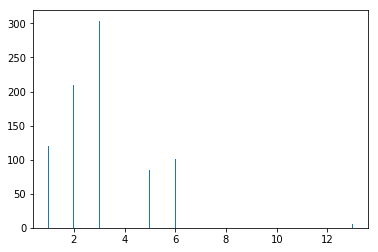

In [26]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

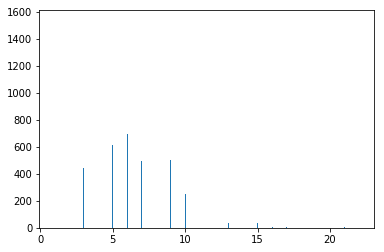

In [27]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

## Build char vocab (all text)

In [28]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

In [29]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [30]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 4000
Number of unique input tokens: 91
Number of unique output tokens: 91
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [31]:
char2int

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '#': 67,
 '$': 80,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 64,
 ')': 65,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 48,
 '/': 29,
 '0': 54,
 '1': 43,
 '2': 53,
 '3': 57,
 '4': 56,
 '5': 74,
 '6': 55,
 '7': 70,
 '8': 61,
 '9': 72,
 ':': 13,
 ';': 75,
 '=': 89,
 '?': 60,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 46,
 'F': 33,
 'G': 41,
 'H': 52,
 'I': 22,
 'J': 68,
 'K': 50,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 45,
 'S': 38,
 'T': 9,
 'U': 49,
 'UNK': 0,
 'V': 14,
 'W': 51,
 'X': 79,
 'Y': 47,
 'Z': 71,
 '^': 86,
 '_': 90,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 59,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 58,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 62,
 'y': 10,
 'z': 63,
 '|': 82,
 '’': 66,
 '•': 84,
 '●': 87,
 'ﬁ': 88}

In [32]:
int2char

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'R',
 46: 'E',
 47: 'Y',
 48: '.',
 49: 'U',
 50: 'K',
 51: 'W',
 52: 'H',
 53: '2',
 54: '0',
 55: '6',
 56: '4',
 57: '3',
 58: 'q',
 59: 'k',
 60: '?',
 61: '8',
 62: 'x',
 63: 'z',
 64: '(',
 65: ')',
 66: '’',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: 'X',
 80: '$',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '=',
 90: '_'}

In [33]:
len(int_to_vocab)

91

## Vectorize char data

In [34]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_char_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Build char model

In [35]:
latent_dim = 256 

In [36]:
model, encoder_model, decoder_model = build_char_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 91)     8281        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 512),  712704      embedding_1[0][0]                
__________________________________________________________________________________________________
embedding_

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


## Fit char model

In [37]:
batch_size = 64  # Batch size for training.
epochs = 10 
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_char-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 28s 9ms/step - loss: 3.4300 - categorical_accuracy: 0.1324 - val_loss: 2.8417 - val_categorical_accuracy: 0.1955

Epoch 00001: val_categorical_accuracy improved from -inf to 0.19554, saving model to best_model_char-50.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
3200/3200 [==============================] - 24s 8ms/step - loss: 2.1259 - categorical_accuracy: 0.3769 - val_loss: 1.9052 - val_categorical_accuracy: 0.4395

Epoch 00002: val_categorical_accuracy improved from 0.19554 to 0.43955, saving model to best_model_char-50.hdf5
Epoch 3/10
3200/3200 [==============================] - 25s 8ms/step - loss: 0.9891 - categorical_accuracy: 0.6963 - val_loss: 0.9788 - val_categorical_accuracy: 0.6921

Epoch 00003: val_categorical_accuracy improved from 0.43955 to 0.69205, saving model to best_model_char-50.hdf5
Epoch 4/10
3200/3200 [==============================] - 21s 7ms/step - loss: 0.3984 - categorical_accuracy: 0.8532 - val_loss: 0.5804 - val_categorical_accuracy: 0.7922

Epoch 00004: val_categorical_accuracy improved from 0.69205 to 0.79217, saving model to best_model_char-50.hdf5
Epoch 5/10
3200/3200 [==============================] - 21s 7ms/step - loss: 0.1973 - categorical_accuracy: 0.9054 - val_loss: 0.3952 - val_categorical_ac

In [38]:
encoder_char_model_file = 'encoder_char_model-{}.hdf5'
decoder_char_model_file = 'decoder_char_model-{}.hdf5'
encoder_model.save('encoder_char_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_char_model-{}.hdf5'.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Train Hierarichal model

## Build word vocab (target_texts)

In [39]:
max_words_seq_len=15
max_chars_seq_len=20

In [40]:
all_texts = target_texts
vocab_to_int, int_to_vocab = build_words_vocab(all_texts)
word2int = vocab_to_int
int2word = int_to_vocab
np.savez('vocab_hier-{}-{}'.format(max_words_seq_len, max_chars_seq_len), char2int=char2int, int2char=int2char, word2int=word2int, int2word=int2word, max_words_seq_len=max_words_seq_len, max_char_seq_len=max_chars_seq_len)


In [41]:
word2int

{'UNK': 0,
 ' ': 1,
 '\t': 2,
 '\n': 3,
 'Claim': 4,
 'Type': 5,
 'VB': 6,
 'Accident': 7,
 'Accidental': 8,
 'Injury': 9,
 'Information': 10,
 'First': 11,
 'Name': 12,
 'Middle': 13,
 'Last': 14,
 'Social': 15,
 'Security': 16,
 'Number': 17,
 'Birth': 18,
 'Date': 19,
 'Gender': 20,
 'Language': 21,
 'Preference': 22,
 'Address': 23,
 'Line': 24,
 'City': 25,
 'Postal': 26,
 'Code': 27,
 'Country': 28,
 'Best': 29,
 'Phone': 30,
 'to': 31,
 'be': 32,
 'Reached': 33,
 'During': 34,
 'the': 35,
 'Day': 36,
 'Email': 37,
 'Page': 38,
 'of': 39,
 'RADIOLOGY': 40,
 'REPORT': 41,
 'Patient': 42,
 'MRN': 43,
 'Accession': 44,
 'No': 45,
 'Ref': 46,
 'Physician': 47,
 'UNKNOWN': 48,
 'Study': 49,
 'Hospital': 50,
 'DOB': 51,
 'Technique': 52,
 'views': 53,
 'left': 54,
 'wrist': 55,
 'Cormarison': 56,
 'None': 57,
 'availabie': 58,
 'Comparison': 59,
 'available': 60,
 'FINDINGS': 61,
 'IMPRESSION': 62,
 'acute': 63,
 'osseous': 64,
 'abnormality': 65,
 'identified': 66,
 'Daytime': 67,
 'E

In [42]:
int2word

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'Claim',
 5: 'Type',
 6: 'VB',
 7: 'Accident',
 8: 'Accidental',
 9: 'Injury',
 10: 'Information',
 11: 'First',
 12: 'Name',
 13: 'Middle',
 14: 'Last',
 15: 'Social',
 16: 'Security',
 17: 'Number',
 18: 'Birth',
 19: 'Date',
 20: 'Gender',
 21: 'Language',
 22: 'Preference',
 23: 'Address',
 24: 'Line',
 25: 'City',
 26: 'Postal',
 27: 'Code',
 28: 'Country',
 29: 'Best',
 30: 'Phone',
 31: 'to',
 32: 'be',
 33: 'Reached',
 34: 'During',
 35: 'the',
 36: 'Day',
 37: 'Email',
 38: 'Page',
 39: 'of',
 40: 'RADIOLOGY',
 41: 'REPORT',
 42: 'Patient',
 43: 'MRN',
 44: 'Accession',
 45: 'No',
 46: 'Ref',
 47: 'Physician',
 48: 'UNKNOWN',
 49: 'Study',
 50: 'Hospital',
 51: 'DOB',
 52: 'Technique',
 53: 'views',
 54: 'left',
 55: 'wrist',
 56: 'Cormarison',
 57: 'None',
 58: 'availabie',
 59: 'Comparison',
 60: 'available',
 61: 'FINDINGS',
 62: 'IMPRESSION',
 63: 'acute',
 64: 'osseous',
 65: 'abnormality',
 66: 'identified',
 67: 'Daytime',
 68

In [43]:
num_word_tokens=len(sorted(list(word2int)))
num_char_tokens=len(sorted(list(char2int)))

## Vecotrize hierarichal data

In [44]:
encoder_char_input_data, decoder_word_input_data, decoder_word_target_data = vectorize_hier_data(input_texts, 
                                                                                                target_texts, 
                                                                                                max_words_seq_len, 
                                                                                                max_chars_seq_len, 
                                                                                                num_char_tokens, 
                                                                                                num_word_tokens, 
                                                                                                word2int, 
                                                                                                char2int)

## Load char encoder

In [45]:
encoder_char_model = load_model(encoder_char_model_file.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Build Hierarichal model

In [46]:
encoder_char_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 91)     8281        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 512),  712704      embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
__________

In [47]:
model, encoder_model, decoder_model = build_hier_model(encoder_char_model=encoder_char_model, 
                              max_words_seq_len=max_words_seq_len,
                              max_char_seq_len=max_chars_seq_len,
                              num_word_tokens=num_word_tokens,
                              num_char_tokens=num_char_tokens, 
                              latent_dim=latent_dim)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 15, 20)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 20)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 20)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 20)           0           input_6[0][0]                    
_____________________________________________________________________________________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [48]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 15, 20)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 20)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 20)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 20)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [49]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 1024)     1031168     input_7[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
lstm_4 (LS

## Fit Hierarichal model

In [50]:
batch_size = 64  # Batch size for training.
epochs = 10
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_model-{}-{}.hdf5".format(max_words_seq_len,max_chars_seq_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit([encoder_char_input_data, decoder_word_input_data], decoder_word_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 78s 25ms/step - loss: 2.4927 - categorical_accuracy: 0.4382 - val_loss: 2.1828 - val_categorical_accuracy: 0.4782

Epoch 00001: val_categorical_accuracy improved from -inf to 0.47820, saving model to best_hier_model-15-20.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_20/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_21/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
3200/3200 [==============================] - 44s 14ms/step - loss: 0.6844 - categorical_accuracy: 0.7060 - val_loss: 1.3884 - val_categorical_accuracy: 0.5663

Epoch 00002: val_categorical_accuracy improved from 0.47820 to 0.56628, saving model to best_hier_model-15-20.hdf5
Epoch 3/10
3200/3200 [==============================] - 45s 14ms/step - loss: 0.3560 - categorical_accuracy: 0.7568 - val_loss: 1.0802 - val_categorical_accuracy: 0.6481

Epoch 00003: val_categorical_accuracy improved from 0.56628 to 0.64807, saving model to best_hier_model-15-20.hdf5
Epoch 4/10
3200/3200 [==============================] - 44s 14ms/step - loss: 0.2349 - categorical_accuracy: 0.7847 - val_loss: 0.9327 - val_categorical_accuracy: 0.6540

Epoch 00004: val_categorical_accuracy improved from 0.64807 to 0.65403, saving model to best_hier_model-15-20.hdf5
Epoch 5/10
3200/3200 [==============================] - 46s 14ms/step - loss: 0.1894 - categorical_accuracy: 0.7920 - val_loss: 0.8922 - val_c

In [51]:
idx = 50

In [52]:
decode_gt_sequence(decoder_word_input_data[idx:idx+1], int2word)

'\t Medical Provider Roles UNK Treating \n UNK UNK UNK UNK UNK UNK UNK UNK '

In [53]:
word_tokenize(input_texts[idx])

['Medicl', 'Providr', 'Royles', ':', 'Teating']

In [54]:
target_texts[idx]

'\tMedical Provider Roles: Treating\n'

In [55]:
words_lst =  word_tokenize(target_texts[idx])
words_lst.insert(0, '\t')
words_lst.append('\n')
words_lst

['\t', 'Medical', 'Provider', 'Roles', ':', 'Treating', '\n']

In [56]:
decode_gt_sequence(np.argmax(decoder_word_target_data[idx:idx+1], axis=-1), int2word)

'Medical Provider Roles UNK Treating \n UNK UNK UNK UNK UNK UNK UNK UNK UNK '

In [57]:
y = model.predict([encoder_char_input_data[idx:idx+1], decoder_word_input_data[idx-1:idx]])
y.shape
#sampled_token_index = np.argmax(y[0, -1, :])
d = np.argmax(y, axis=-1)
d.shape
decode_gt_sequence(d, int2word)

'Medical Provider Roles UNK UNK \n \n \n \n \n \n \n \n \n \n '

In [58]:
input_seq = encoder_char_input_data[idx:idx+1]
decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
print(decoded_sentence)

Medical Provider Roles UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  


In [59]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_char_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_word_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: lCaim Tpyze: VBAicciwden -A ccidental Injry
GT sentence: Claim Type: VB Accident - Accidental Injury
Decoded sentence: Claim Type UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Polcyholder/Owner Information
GT sentence: Policyholder/Owner Information
Decoded sentence: UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: First Name:
GT sentence: First Name:
Decoded sentence: First Name UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Middle Nmae/Initial:
GT sentence: Middle Name/Initial:
Decoded sentence: Middle UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Las tName:
GT sentence: Last Name:
Decoded sentence: Last Name UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Sjocmial Seurity Number:
GT sentence: Social Security Number:
Decoded sentence: Individual Family UNK UNK  
-
Input sentence: Brth Datje:
GT sentence: Birth Da

-
Input sentence: State/Provincwe:
GT sentence: State/Province:
Decoded sentence: UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Posgtal Code

GT sentence: Postal Code:
Decoded sentence: Postal Code UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Cuountry:
GT sentence: Country:
Decoded sentence: Country UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Businss Teblephone:
GT sentence: Business Telephone:
Decoded sentence: Business Telephone UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Busness Fax
GT sentence: Business Fax
Decoded sentence: Business Fax  
-
Input sentence: Date xf First Visit:
GT sentence: Date of First Visit:
Decoded sentence: Date of First Visit UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK  
-
Input sentence: Date of Next Visit:
GT sentence: Date of Next Visit:
Decoded sentence: Date of Next Visit UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 

In [60]:
input_texts = ['text',
'',
'',
'',
'',
' ',
'',
'',
'',
'Fai',
'10',
'7521509',
'(FISTDEOO)',
'at',
'11/3/2017',
'5:23:19',
'from',
'-9373834004',
'Req',
'IC',
'2017:1030525109:292E.',
'Page',
'4',
'of',
'5',
'(C)',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
'11/3/2017',
'FRI',
'8:26',
'FAX',
'2373834004',
'Kjooas00s',
'',
'',
'',
'as3-ursasy3',
'11:30:11',
'11/2/2017',
'vis',
'',
'',
'',
'®',
'®',
'&',
'ACCIDENT',
'CLAIM',
'FORM',
'',
'uu',
'num’',
'Tha',
'Benelits',
'Canter',
'',
'P.O.',
'Bax',
'100158,',
'Calumbin,',
'EC',
'20202-3150',
'',
'Tol-frea:',
'1-800-635-5587',
'Fax:',
'1-800-447-2488',
'',
'Gall',
'toll-free',
'Monday',
'through',
'Friday,',
'8',
'a.m.',
'lo',
'8',
'p.m,',
'Eagtarn',
'Time.',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
'[',
'ATTENDING',
'PHYSICIAN',
'STATEMENT',
']',
'',
'',
'IneurexiPolicyt',
'alcar',
'Hama',
'(Lael',
'Name,',
'Flis!',
'Nama,',
'MI,',
'Suffix)',
'Data',
'of',
'Risth',
'{msmidrfyy)',
'-',
'',
'',
'Faupi',
'Nana',
'{Laut',
'Hume,',
'Flial',
'Numa,',
'1',
'Sut)',
'Dats',
'al',
'Bln',
'rAvad)',
'Ul',
'_',
'',
'-[ECIpENT',
'DETAILS',
']',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
'a',
'thls',
'Gundilan',
'the',
'result',
'of',
'a',
'acddental',
'inury?',
'ves',
'O',
'No',
'if',
'yas,',
'dale',
'of',
'accident',
'qre/ddlyy)',
'[1',
'0]',
'[z]e',
'[=]',
'',
'',
'',
'Is',
'Mig',
'condition',
'Lhe',
'result',
'of',
'hefer',
'employment',
'£1',
'Yes',
'pNo',
'[1',
'Unknown',
'',
'',
'',
'Plaaze',
'verily',
'treatment',
'for',
'the',
'accident',
'lalad',
'above.',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
'Dalaw',
'of',
'Diagnosis',
'Diagncsis',
'Description',
'Prosadure',
'Procedure',
'Dascription',
'',
'Branden',
'(Including',
'|',
'Cudo',
'(GD)',
'ous',
'',
'Confinement)',
'eR',
'ap',
'HAS',
'TTT',
'',
'BEEF',
'eR',
'',
'wiz]',
'.',
'S33,5XxA',
'Hh',
'rioes',
'ey',
'race',
'Word',
'',
'awqd]',
'',
'weak',
'3',
'n',
'[aveny',
'[d',
'',
'wifi',
'Wl',
'',
'oa',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
'Has',
'lhe',
'pallet',
'bean',
'trastad',
'for',
'tha',
'same',
'ar',
'&',
'S(tilar',
'candillan',
'by',
'anolher',
'phyalelan',
'In',
'tha',
'past?',
'[1',
'Yen',
'Bho',
'',
'M',
'yor,',
'pioona',
'provid',
'tha',
'fares:',
'',
'',
'',
' ',
'',
'',
'',
'Diageosis:',
'Tramiment',
'Daten:',
'',
'',
'',
' ',
'',
'',
'',
' ',
'',
'',
'',
'id',
'ya.1',
'#dving',
'Lhe',
'patient',
'to',
'clap',
'working?',
'RECEIVED',
'',
'It',
'yes,',
'B8',
'of',
'what',
'cate?',
'(mmidkyy)',
'',
'',
'',
'[23]',
'[117]',
'',
'',
'',
'[Ih',
'cielih',
'fa',
'rotated',
'to',
'normal',
'prepnency,',
'please',
'grovida',
'tha',
'idliawing:',
'NOV',
'',
'Expecigd',
'Delivery',
'Dale',
'(mimicd/yy)',
'Aclual',
'Delivery',
'Dale',
'{mmiddlyy',
'',
'',
'',
' ',
'',
'',
'',
'Phyeiclan',
'informaiton',
'HUMAN',
'REGOURCITE',
'',
'',
'',
'FRAUD',
'NOTICE:',
'Any',
'person',
'wha',
'knowingly',
'files',
'&',
'statement',
'of',
'clalm',
'containing',
'FALSE',
'or',
'misleading',
'information',
'8',
'',
'subject',
'to',
'criminal',
'and',
'elvil',
'penallies.',
'This',
'includes',
'Attending',
'Physician',
'portions',
'of',
'the',
'claim',
'farm.',
'',
'',
'',
'CS',
'yma',
'SEAS',
'Ta',
'hve',
'glan',
'=',
'',
'The',
'above',
'statements',
'ara',
'trun',
'And',
'rompints',
'to',
'tho',
'bot',
'of',
'my',
'knowledge',
'and',
'bolluf.',
'',
'',
'',
'Physician',
'Name',
'(Lea!',
'Name,',
'Firat',
'Name,',
'MI,',
'Suita)',
'Plases',
'Print',
'Co',
'FHman',
'log',
'Mm',
'',
'/',
'‘',
'',
'',
'',
'Medical',
'Speclaty',
'[Tr',
'eactal-',
']',
'|',
'D',
'of',
'r',
'of',
'Ch',
'2',
'',
'2',
'Le',
'',
'',
'==',
'Zoi!',
'M',
'o',
'“Fanart',
'',
'',
'=',
'Balfrone',
'ie',
'2',
'Sle',
'iu',
'',
'il',
'HY',
'BY',
'1942',
'Fax',
'Number',
'yz—',
'43',
'-8',
'7775',
'Fhyalafans',
'Tax',
'ID',
'Number.',
'',
'',
'',
'Aro',
'you',
'refateq',
'to',
'hiv',
'pollen?',
'0',
'Yoe',
'LlMo',
'|',
'yes,',
'wal',
'iv',
'the',
'relelianshipT',
'',
'',
'',
' ',
'',
'',
'',
' ',
' ',
'',
'',
'',
'Physlclan',
'Slgnature',
'Date',
'',
'CL-1023',
'-2717',
'=',
'',
'',
'',
' ',
'',
'',
'',
'—',]

encoder_char_input_data, decoder_word_input_data, decoder_word_target_data = vectorize_hier_data(input_texts, 
                                                                                                [], 
                                                                                                max_words_seq_len, 
                                                                                                max_chars_seq_len, 
                                                                                                num_char_tokens, 
                                                                                                num_word_tokens, 
                                                                                                word2int, 
                                                                                                char2int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_char_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_word_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: text
GT sentence: Claim Type: VB Accident - Accidental Injury
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Policyholder/Owner Information
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: First Name:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Middle Name/Initial:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Last Name:
Decoded sentence: Procedure Description  
-
Input sentence:  
GT sentence: Social Security Number:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Birth Date:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Gender:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Language Preference:
Decoded sentence: Procedure Description  
-
Input sentence: Fai
GT sentence: Address Line 1:
Decoded sentence: Procedure Description  
-
Input sentence: 10
GT sentence: City:
Decoded sent

-
Input sentence: 8
GT sentence: Printed Name Social Security Number
Decoded sentence: Procedure Description  
-
Input sentence: p.m,
GT sentence: CL-1116 (11/14)
Decoded sentence: Procedure Description  
-
Input sentence: Eagtarn
GT sentence: Unum
Decoded sentence: Procedure Description  
-
Input sentence: Time.
GT sentence: Confirmation of Coverage
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Employer:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Group Policy #:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Customer  Policy #:
Decoded sentence: Procedure Description  
-
Input sentence:  
GT sentence: EE Name:
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Insured Coverage Type Coverage Effective Date
Decoded sentence: Procedure Description  
-
Input sentence: 
GT sentence: Employee Off-Job Acc January 1, 2017
Decoded sentence: Procedure Description  
-
Input sentence: 
GT 